
# FFNN — PyTorch 2.x (simplificado)

Este cuaderno combina el **pipeline compacto** con `torch.compile`, early stopping y utilidades modernas,
**añadiendo** las funciones/clases que tenía tu versión original (datasets, EDA, loops `loop_FFNN/MC`,
`evaluate`, plots, etc.).


In [ ]:

# [setup]
import os, math, time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.datasets import load_breast_cancer, load_iris, load_wine
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt

torch.set_float32_matmul_precision('high')
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
os.makedirs('checkpoints', exist_ok=True)
print('Device:', DEVICE)


Device: cpu


In [ ]:

# [model core]
def make_mlp(d_in: int, d_hidden=(64, 64), d_out=1, dropout=0.0, act=nn.ReLU):
    layers = []
    d_prev = d_in
    for h in d_hidden:
        layers += [nn.Linear(d_prev, h), act()]
        if dropout > 0: layers += [nn.Dropout(dropout)]
        d_prev = h
    layers += [nn.Linear(d_prev, d_out)]
    return nn.Sequential(*layers)

@torch.no_grad()
def accuracy_bin(logits, y_true):
    preds = (logits.sigmoid() >= 0.5).float().view(-1)
    return (preds == y_true.view(-1)).float().mean().item()

@torch.no_grad()
def accuracy_multi(logits, y_true):
    preds = logits.argmax(1)
    return (preds == y_true).float().mean().item()

def set_seed(seed=42):
    import random
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)


In [ ]:

# [fit loop]
def fit(model, train_ds, val_ds=None, *, epochs=100, batch_size=64, lr=1e-3,
        patience=10, min_delta=1e-4, ckpt_path=None, compile_model=True, weight_decay=0.0):
    model.to(DEVICE)
    if compile_model and hasattr(torch, 'compile'):
        try:
            model = torch.compile(model)  # PyTorch 2.x
        except Exception as e:
            print('torch.compile no disponible:', e)

    sample_x, sample_y = train_ds[:][0], train_ds[:][1]
    binary = sample_y.ndim == 2 or sample_y.unique().numel() <= 2
    if binary:
        criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.CrossEntropyLoss()

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    best = math.inf; best_epoch = None; best_state = None
    history = {'epoch': [], 'loss': [], 'acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, epochs+1):
        model.train()
        epoch_loss = 0.0; n = 0; accs = []
        for xb, yb in train_loader:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)
            logits = model(xb)
            if binary:
                yb_f = yb.float().view(-1,1)
                loss = criterion(logits, yb_f)
                acc = accuracy_bin(logits.detach(), yb.detach().float())
            else:
                loss = criterion(logits, yb.long())
                acc = accuracy_multi(logits.detach(), yb.detach().long())
            opt.zero_grad(set_to_none=True); loss.backward(); opt.step()
            epoch_loss += loss.item()*xb.size(0); n += xb.size(0); accs.append(acc)
        tr_loss = epoch_loss/n; tr_acc = float(np.mean(accs))

        # Validación
        if val_ds is not None:
            model.eval()
            xb, yb = val_ds[:]
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            with torch.no_grad():
                logits = model(xb)
                if binary:
                    val_loss = criterion(logits, yb.float().view(-1,1)).item()
                    val_acc = accuracy_bin(logits, yb.float())
                else:
                    val_loss = criterion(logits, yb.long()).item()
                    val_acc = accuracy_multi(logits, yb.long())
            if val_loss + min_delta < best:
                best = val_loss; best_epoch = epoch; best_state = {k:v.cpu() for k,v in model.state_dict().items()}
                if ckpt_path: torch.save(best_state, ckpt_path)

        history['epoch'].append(epoch)
        history['loss'].append(tr_loss); history['acc'].append(tr_acc)
        if val_ds is not None:
            history['val_loss'].append(val_loss); history['val_acc'].append(val_acc)

        if epoch % 5 == 0:
            msg = f"[{epoch:03d}] loss={tr_loss:.4f} acc={tr_acc*100:5.1f}%"
            if val_ds is not None:
                msg += f" | vloss={val_loss:.4f} vacc={val_acc*100:5.1f}%"
            print(msg)

        # early stopping
        if val_ds is not None and (epoch - (best_epoch or 0)) >= patience:
            print(f"Paro temprano @ epoch {epoch} (best={best_epoch})")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    return model, history, best_epoch


In [ ]:

# [tensor dataset helper]
def to_tensor_dataset(X, y, *, standardize=False, test_size=0.2, val_size=0.2, seed=42, y_is_float=False):
    if standardize:
        scaler = StandardScaler().fit(X)
        X = scaler.transform(X)
    X = torch.tensor(X, dtype=torch.float32)
    if y_is_float:
        y = torch.tensor(y, dtype=torch.float32).view(-1)
    else:
        y = torch.tensor(y, dtype=torch.long).view(-1)
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=test_size, stratify=y if not y_is_float else None, random_state=seed)
    X_tr, X_val, y_tr, y_val = train_test_split(X_tr, y_tr, test_size=val_size, stratify=y_tr if not y_is_float else None, random_state=seed)
    return (TensorDataset(X_tr, y_tr), TensorDataset(X_val, y_val), TensorDataset(X_te, y_te))


In [ ]:

# [compat: datasets & splits]
class RandomDataSet(Dataset):
    def __init__(self, N=600, D=40, seed=0):
        set_seed(seed)
        X = np.random.randn(N, D)
        w = np.random.randn(D); logits = X@w + 0.25*np.random.randn(N)
        y = (logits > 0).astype(np.float32)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.num_features = D
        self.num_classes = 2
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

class BreastCancerBinaryDataset(Dataset):
    def __init__(self, standardize=True):
        data = load_breast_cancer()
        X, y = data.data, data.target.astype(np.float32)
        if standardize:
            X = StandardScaler().fit_transform(X)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.num_features = self.X.shape[1]
        self.num_classes = 2
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

class IrisDataset(Dataset):
    def __init__(self, standardize=True):
        data = load_iris()
        X, y = data.data, data.target.astype(np.int64)
        if standardize:
            X = StandardScaler().fit_transform(X)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.num_features = self.X.shape[1]
        self.num_classes = int(np.unique(y).size)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

class WineDataset(Dataset):
    def __init__(self, standardize=True):
        data = load_wine()
        X, y = data.data, data.target.astype(np.int64)
        if standardize:
            X = StandardScaler().fit_transform(X)
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
        self.num_features = self.X.shape[1]
        self.num_classes = int(np.unique(y).size)
    def __len__(self): return self.X.shape[0]
    def __getitem__(self, i): return self.X[i], self.y[i]

def make_breast_cancer_splits(test=0.2, val=0.2, seed=42):
    X = BreastCancerBinaryDataset().X.numpy()
    y = BreastCancerBinaryDataset().y.numpy()
    return to_tensor_dataset(X, y, standardize=False, test_size=test, val_size=val, seed=seed, y_is_float=True)

def make_iris_splits(test=0.2, val=0.2, seed=42):
    X = IrisDataset().X.numpy()
    y = IrisDataset().y.numpy()
    return to_tensor_dataset(X, y, standardize=False, test_size=test, val_size=val, seed=seed, y_is_float=False)

def make_wine_splits(test=0.2, val=0.2, seed=42):
    X = WineDataset().X.numpy()
    y = WineDataset().y.numpy()
    return to_tensor_dataset(X, y, standardize=False, test_size=test, val_size=val, seed=seed, y_is_float=False)


In [ ]:

# [compat: EDA helpers]
def eda_hist_grid(X, bins=20, title_prefix=""):
    Xn = np.asarray(X); d = Xn.shape[1]
    cols = min(6, d); rows = int(np.ceil(d/cols))
    plt.figure(figsize=(2.8*cols, 2.2*rows))
    for i in range(d):
        ax = plt.subplot(rows, cols, i+1)
        ax.hist(Xn[:,i], bins=bins)
        ax.set_title(f'Var {i}')
    plt.suptitle(f'{title_prefix} - Histogramas'); plt.tight_layout(); plt.show()

def eda_corr_heatmap(X, title_prefix=""):
    Xn = np.asarray(X)
    corr = np.corrcoef(Xn, rowvar=False)
    plt.figure(figsize=(5,4))
    im = plt.imshow(corr, aspect='auto'); plt.colorbar(im)
    plt.title(f"{title_prefix} - Correlación (Pearson)"); plt.xlabel('Feature'); plt.ylabel('Feature'); plt.show()

def eda_feature_bars(X, title_prefix=""):
    Xn = np.asarray(X)
    means = Xn.mean(axis=0); stds = Xn.std(axis=0)
    idx = np.arange(Xn.shape[1])
    plt.figure(figsize=(8,3)); plt.bar(idx, means); plt.title(f"{title_prefix} - Media por variable")
    plt.xlabel('Feature'); plt.ylabel('Media'); plt.show()
    plt.figure(figsize=(8,3)); plt.bar(idx, stds); plt.title(f"{title_prefix} - Desvío estándar por variable")
    plt.xlabel('Feature'); plt.ylabel('STD'); plt.show()

def plot_randomdataset_class_balance(y, title_prefix="Random"):
    y = np.asarray(y).astype(int)
    vals, counts = np.unique(y, return_counts=True)
    plt.figure(figsize=(4,3)); plt.bar(vals, counts); plt.title(f"{title_prefix} - Balance de clases"); plt.xlabel('Clase'); plt.ylabel('Count'); plt.show()

def plot_randomdataset_feature_density(X, idx=0, title_prefix="Random"):
    Xn = np.asarray(X)
    plt.figure(figsize=(4,3)); plt.hist(Xn[:, idx], bins=30); plt.title(f"{title_prefix} - Densidad feature {idx}"); plt.show()

def plot_randomdataset_heatmap(X, title_prefix="Random"):
    eda_corr_heatmap(X, title_prefix=title_prefix)

def plot_randomdataset_sample_ones_hist(X, y, title_prefix="Random"):
    Xn = np.asarray(X); y = np.asarray(y).astype(int)
    X1 = Xn[y==1]
    if X1.size==0:
        print("No hay clase 1 en la muestra"); return
    eda_hist_grid(X1, title_prefix=f"{title_prefix} (clase 1)")


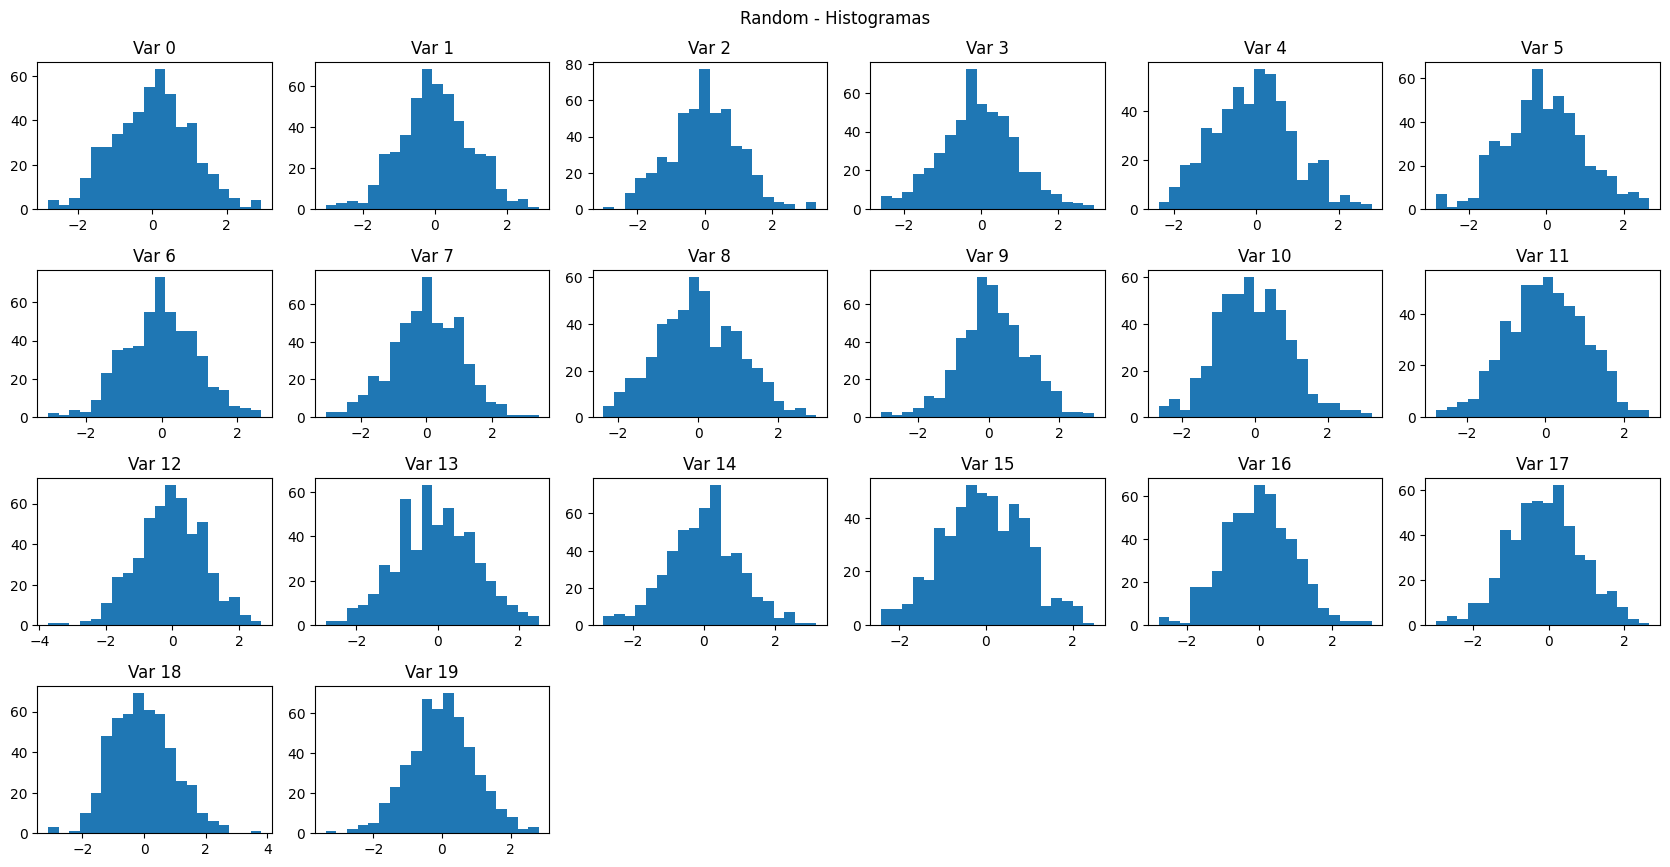

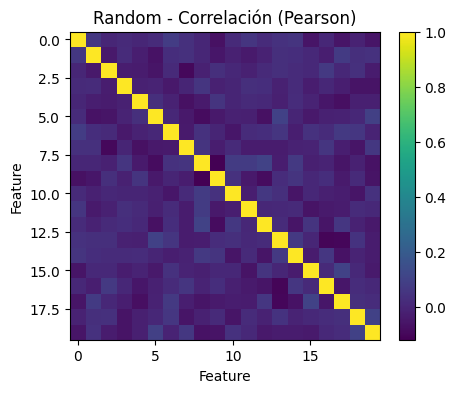

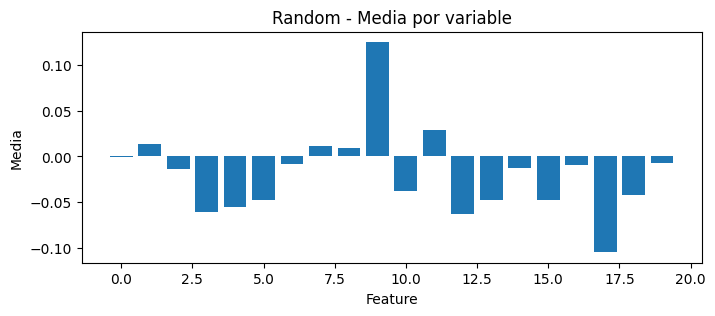

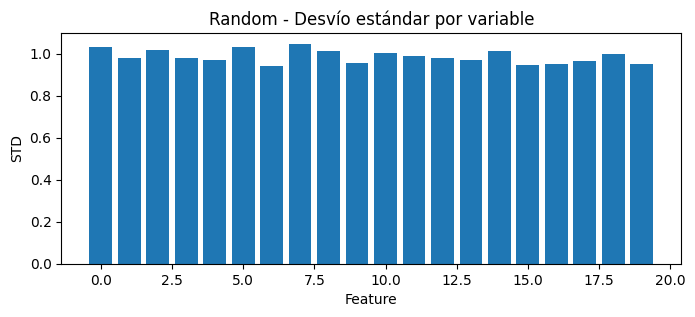

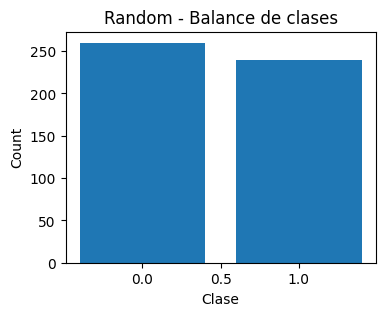

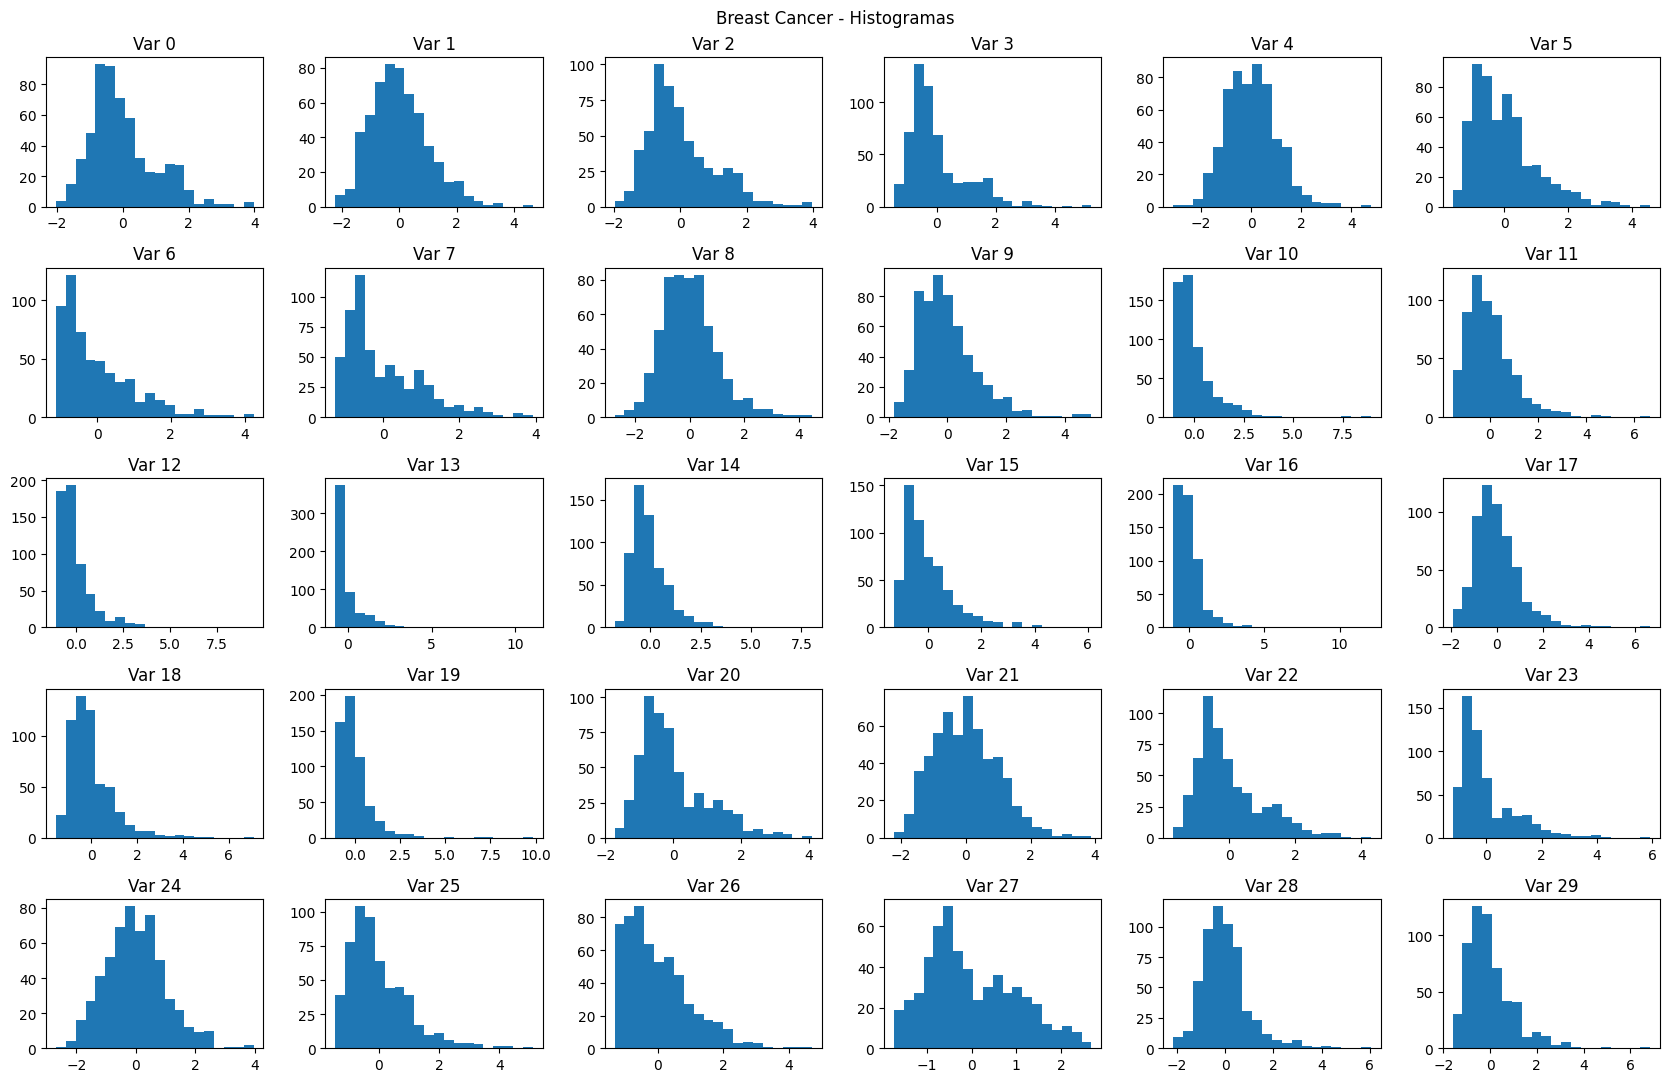

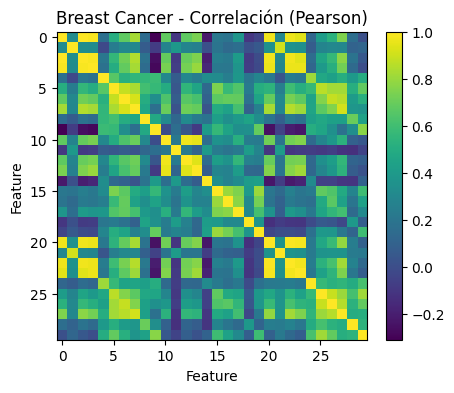

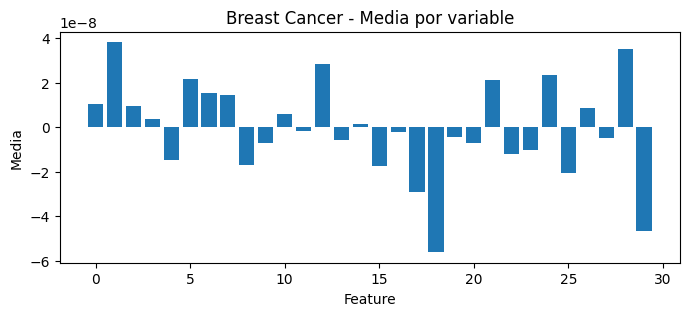

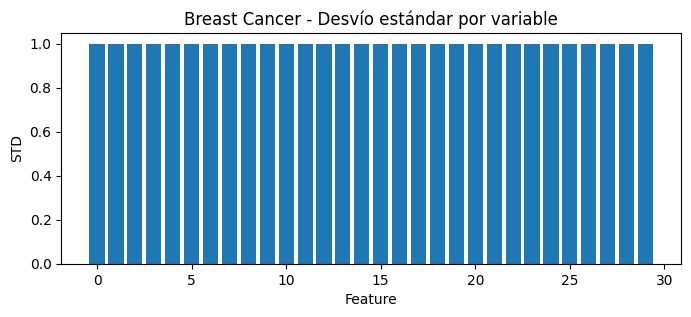

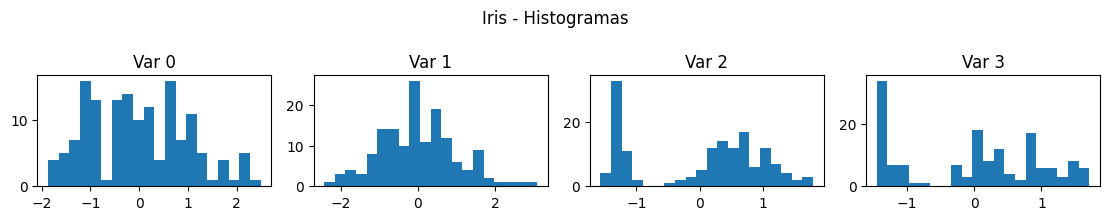

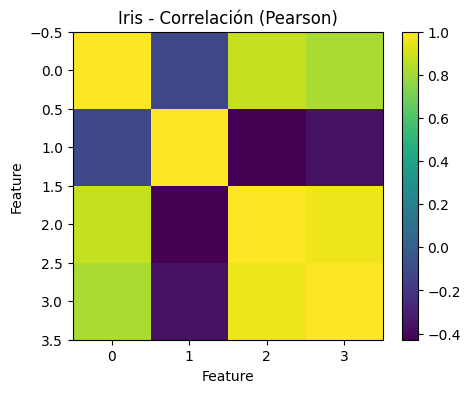

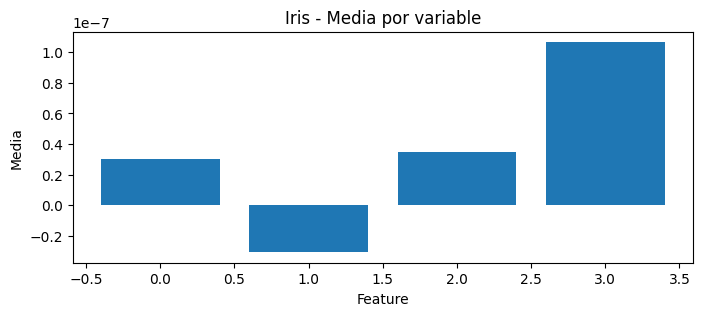

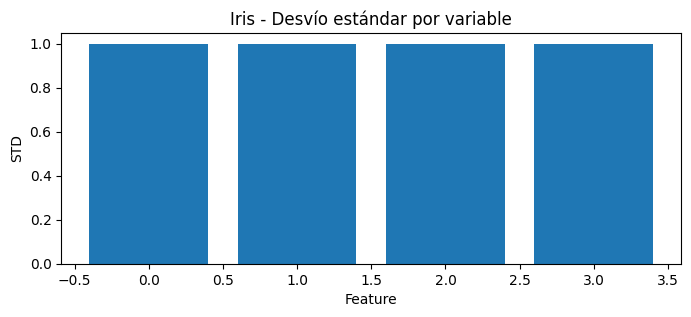

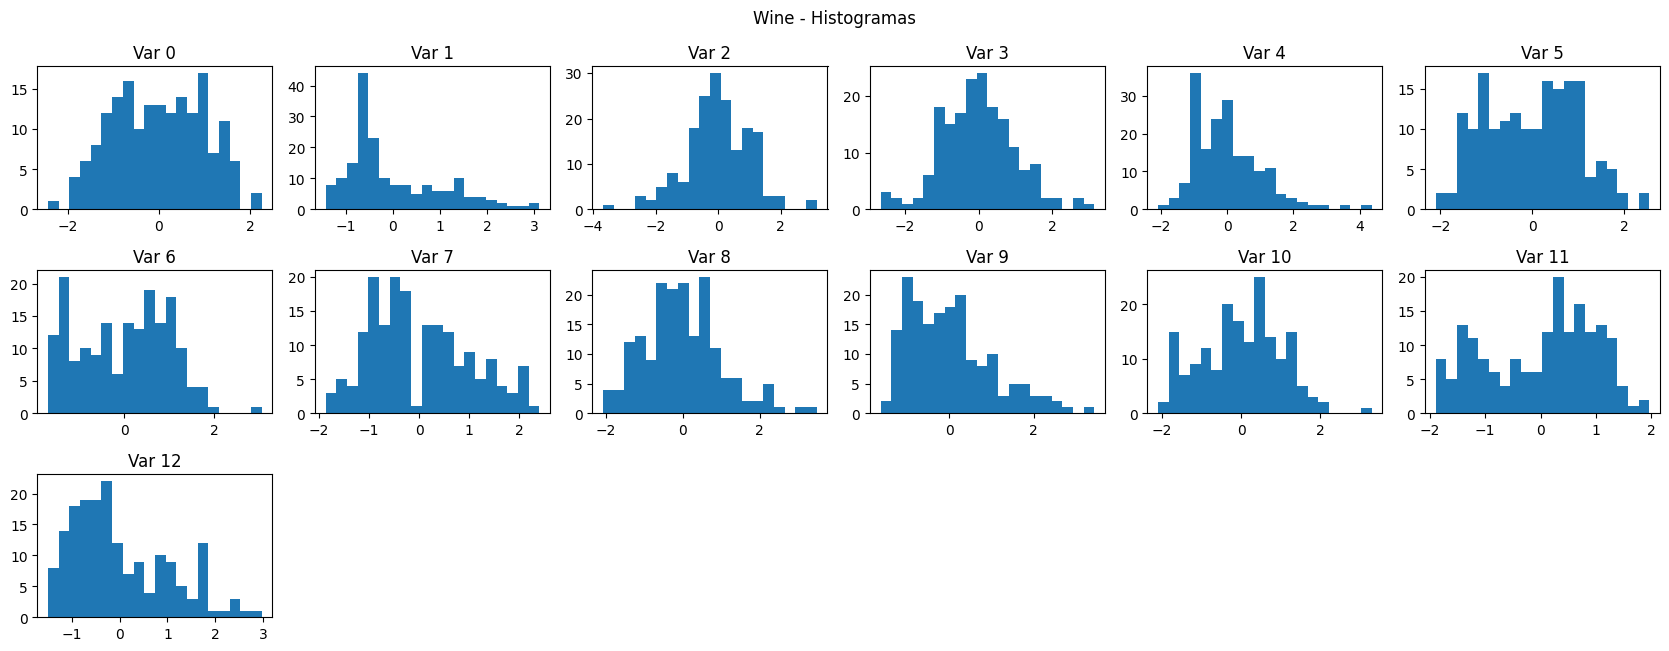

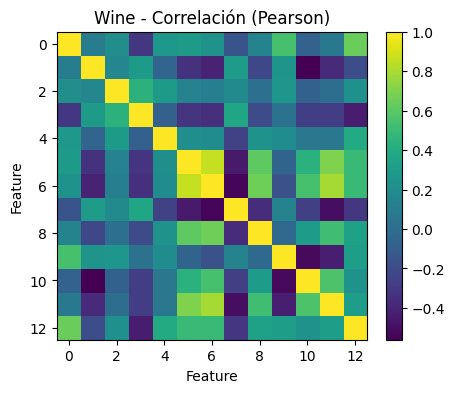

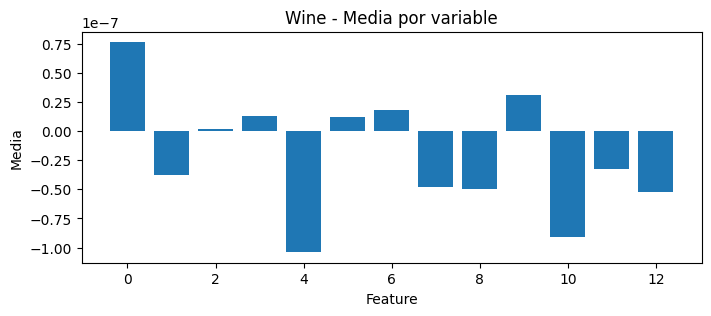

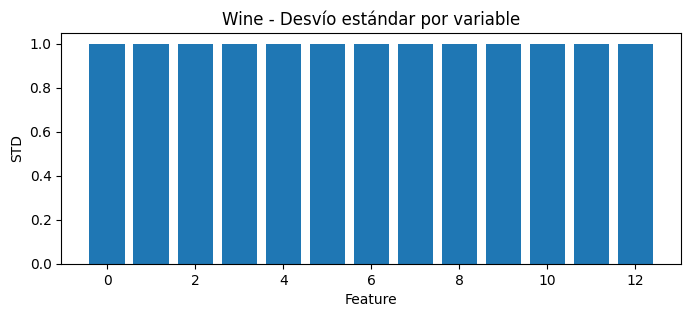

In [ ]:
# [EDA de datasets]
# Random (sólo a modo ilustrativo)
rnd_eda = RandomDataSet(N=500, D=20, seed=0)
eda_hist_grid(rnd_eda.X.numpy(), title_prefix="Random")
eda_corr_heatmap(rnd_eda.X.numpy(), title_prefix="Random")
eda_feature_bars(rnd_eda.X.numpy(), title_prefix="Random")
plot_randomdataset_class_balance(rnd_eda.y.numpy(), title_prefix="Random")

# Breast Cancer
bc = BreastCancerBinaryDataset(standardize=True)
eda_hist_grid(bc.X.numpy(), title_prefix="Breast Cancer")
eda_corr_heatmap(bc.X.numpy(), title_prefix="Breast Cancer")
eda_feature_bars(bc.X.numpy(), title_prefix="Breast Cancer")

# Iris
iris_ds = IrisDataset(standardize=True)
eda_hist_grid(iris_ds.X.numpy(), title_prefix="Iris")
eda_corr_heatmap(iris_ds.X.numpy(), title_prefix="Iris")
eda_feature_bars(iris_ds.X.numpy(), title_prefix="Iris")

# Wine
wine_ds = WineDataset(standardize=True)
eda_hist_grid(wine_ds.X.numpy(), title_prefix="Wine")
eda_corr_heatmap(wine_ds.X.numpy(), title_prefix="Wine")
eda_feature_bars(wine_ds.X.numpy(), title_prefix="Wine")


In [ ]:

# [compat: models with names FFNN / FFNN_MC]
class FFNN(nn.Module):
    # Binario: salida 1
    def __init__(self, d0, d1=64, d2=64, dropout=0.0):
        super().__init__()
        self.net = make_mlp(d0, (d1, d2), 1, dropout=dropout)
    def forward(self, x): return self.net(x)

class FFNN_MC(nn.Module):
    # Multiclase: salida C
    def __init__(self, d0, d1=64, d2=64, C=3, dropout=0.0):
        super().__init__()
        self.net = make_mlp(d0, (d1, d2), C, dropout=dropout)
    def forward(self, x): return self.net(x)


In [ ]:

# [compat: evaluation & plotting]
@torch.no_grad()
def evaluate(model, dataset, binary=True, batch_size=256):
    model.eval(); loader = DataLoader(dataset, batch_size=batch_size)
    total=0; correct=0; losses=[]; crit = nn.BCEWithLogitsLoss() if binary else nn.CrossEntropyLoss()
    all_y=[]; all_p=[]
    for xb, yb in loader:
        xb = xb.to(DEVICE); yb = yb.to(DEVICE)
        logits = model(xb)
        if binary:
            loss = crit(logits, yb.float().view(-1,1))
            preds = (logits.sigmoid()>=0.5).float().view(-1)
            all_p.append(preds.cpu().numpy()); all_y.append(yb.view(-1).cpu().numpy())
        else:
            loss = crit(logits, yb.long())
            preds = logits.argmax(1)
            all_p.append(preds.cpu().numpy()); all_y.append(yb.view(-1).cpu().numpy())
        total += yb.size(0); correct += (preds == yb.view(-1)).float().sum().item(); losses.append(loss.item())
    acc = correct/total
    y_true = np.concatenate(all_y); y_pred = np.concatenate(all_p)
    cm = confusion_matrix(y_true, y_pred)
    rep = classification_report(y_true, y_pred, output_dict=False)
    return {'acc': acc, 'loss': float(np.mean(losses)), 'cm': cm, 'report': rep}

@torch.no_grad()
def evaluate_per_class(model, dataset, binary=False, batch_size=256):
    # simple wrapper que devuelve matriz de confusión y métricas por clase del classification_report
    e = evaluate(model, dataset, binary=binary, batch_size=batch_size)
    return e

def plot_history_loss(h):
    x = h['epoch'];
    plt.figure(); plt.plot(x, h['loss'], label='train_loss')
    if h.get('val_loss'): plt.plot(x, h['val_loss'], label='val_loss')
    plt.xlabel('Época'); plt.ylabel('Loss'); plt.title('Histórico Loss'); plt.legend(); plt.show()

def plot_history_acc(h):
    x = h['epoch'];
    plt.figure(); plt.plot(x, np.array(h['acc'])*100, label='train_acc')
    if h.get('val_acc'): plt.plot(x, np.array(h['val_acc'])*100, label='val_acc')
    plt.xlabel('Época'); plt.ylabel('Acc (%)'); plt.title('Histórico Acc'); plt.legend(); plt.show()

def plot_with_best_epoch(h, best_epoch):
    plot_history_loss(h); plot_history_acc(h)
    if best_epoch:
        print(f"Mejor época (val_loss): {best_epoch}")


In [ ]:

# [plots with best epoch]
def plot_history(h, best_epoch=None, title='Histórico'):
    x = h['epoch']
    # Loss
    plt.figure()
    plt.plot(x, h['loss'], label='train_loss')
    if h.get('val_loss') and len(h['val_loss']) == len(x):
        plt.plot(x, h['val_loss'], label='val_loss')
    if best_epoch:
        plt.axvline(best_epoch, linestyle='--')
        plt.text(best_epoch, plt.ylim()[1]*0.9, f"best={best_epoch}", rotation=90, va='top')
    plt.xlabel('Época'); plt.ylabel('Loss'); plt.title(title + ' - Loss'); plt.legend(); plt.show()
    # Acc
    plt.figure()
    plt.plot(x, [a*100 for a in h['acc']], label='train_acc')
    if h.get('val_acc') and len(h['val_acc']) == len(x):
        plt.plot(x, [a*100 for a in h['val_acc']], label='val_acc')
    if best_epoch:
        plt.axvline(best_epoch, linestyle='--')
        plt.text(best_epoch, plt.ylim()[1]*0.9, f"best={best_epoch}", rotation=90, va='top')
    plt.xlabel('Época'); plt.ylabel('Acc (%)'); plt.title(title + ' - Acc'); plt.legend(); plt.show()

def plot_with_best_epoch(h, best_epoch):
    plot_history(h, best_epoch=best_epoch, title='Entrenamiento')


In [ ]:

# [compat: checkpoint & loops]
def load_checkpoint(model, path):
    state = torch.load(path, map_location='cpu')
    model.load_state_dict(state)
    return model

def loop_FFNN(dataset, batch_size, d1, d2, lr, epochs,
              run_in_GPU=True, reports_every=1, cheq_grad=False,
              log_history=False, val_dataset=None, early_stopping=False,
              patience=10, min_delta=1e-4, checkpoint_path=None, weight_decay=0.0):
    d0 = dataset.num_features
    model = FFNN(d0, d1, d2).to(DEVICE if run_in_GPU else 'cpu')
    # Adapter: wrap dataset into TensorDataset for our fit()
    X = dataset.X; y = dataset.y
    # train/val split if val_dataset not provided
    if val_dataset is None:
        X_tr, X_val, y_tr, y_val = train_test_split(X.numpy(), y.numpy(), test_size=0.2, stratify=(y.numpy().round() if y.dtype==torch.float32 else y.numpy()), random_state=42)
        tr = TensorDataset(torch.tensor(X_tr, dtype=torch.float32), torch.tensor(y_tr, dtype=torch.float32))
        val = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
    else:
        tr = TensorDataset(dataset.X, dataset.y)
        val = TensorDataset(val_dataset.X, val_dataset.y)
    model, hist, best = fit(model, tr, val_ds=val if early_stopping or val_dataset is not None else None,
                            epochs=epochs, lr=lr, batch_size=batch_size, patience=patience,
                            min_delta=min_delta, ckpt_path=checkpoint_path, weight_decay=weight_decay)
    if log_history:
        plot_with_best_epoch(hist, best)
    return model, hist, best

def loop_FFNN_MC(dataset, C, batch_size, d1, d2, lr, epochs,
                 run_in_GPU=True, reports_every=1, cheq_grad=False,
                 log_history=False, val_dataset=None, early_stopping=False,
                 patience=10, min_delta=1e-4, checkpoint_path=None, weight_decay=0.0):
    d0 = dataset.num_features
    model = FFNN_MC(d0, d1, d2, C=C).to(DEVICE if run_in_GPU else 'cpu')
    X = dataset.X; y = dataset.y
    if val_dataset is None:
        X_tr, X_val, y_tr, y_val = train_test_split(X.numpy(), y.numpy(), test_size=0.2, stratify=y.numpy(), random_state=42)
        tr = TensorDataset(torch.tensor(X_tr, dtype=torch.float32), torch.tensor(y_tr, dtype=torch.long))
        val = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.long))
    else:
        tr = TensorDataset(dataset.X, dataset.y)
        val = TensorDataset(val_dataset.X, val_dataset.y)
    model, hist, best = fit(model, tr, val_ds=val if early_stopping or val_dataset is not None else None,
                            epochs=epochs, lr=lr, batch_size=batch_size, patience=patience,
                            min_delta=min_delta, ckpt_path=checkpoint_path, weight_decay=weight_decay)
    if log_history:
        plot_with_best_epoch(hist, best)
    return model, hist, best


W1104 22:55:26.624000 144 torch/utils/cpp_extension.py:118] [0/0] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


[005] loss=0.0139 acc= 99.8% | vloss=0.0849 vacc= 98.0%
[010] loss=0.0005 acc=100.0% | vloss=0.1237 vacc= 95.0%
[015] loss=0.0002 acc=100.0% | vloss=0.1495 vacc= 94.0%
Paro temprano @ epoch 15 (best=5)


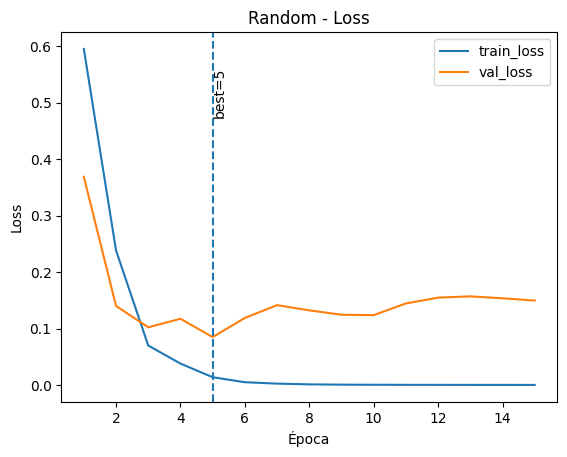

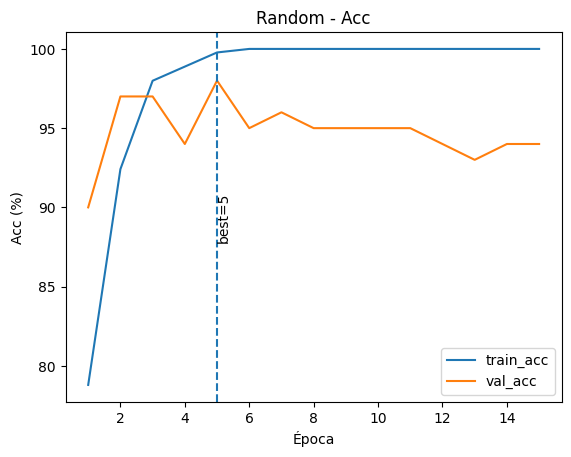

Eval Random: 0.988
[005] loss=0.1013 acc= 97.3% | vloss=0.1102 vacc= 95.6%
[010] loss=0.0493 acc= 99.0% | vloss=0.0904 vacc= 95.6%
[015] loss=0.0328 acc= 99.2% | vloss=0.0886 vacc= 95.6%
[020] loss=0.0227 acc= 99.4% | vloss=0.0953 vacc= 94.7%
[025] loss=0.0152 acc= 98.6% | vloss=0.0993 vacc= 95.6%
Paro temprano @ epoch 26 (best=16)


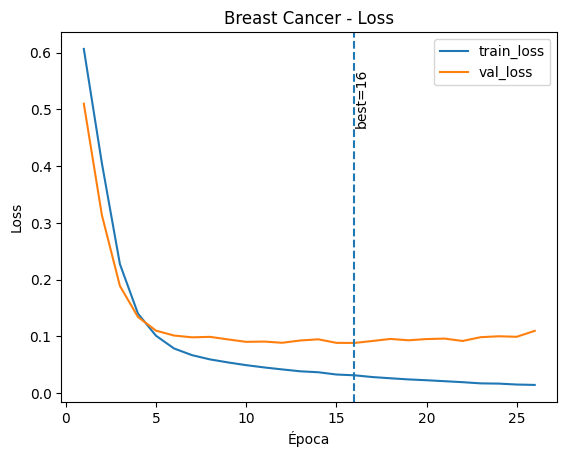

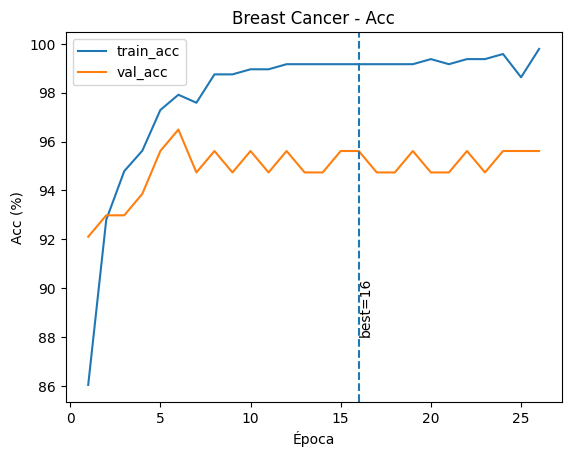

              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       212
         1.0       1.00      0.99      0.99       357

    accuracy                           0.99       569
   macro avg       0.99      0.99      0.99       569
weighted avg       0.99      0.99      0.99       569

[[211   1]
 [  4 353]]
[005] loss=0.2751 acc= 90.4% | vloss=0.2738 vacc= 86.7%
[010] loss=0.0803 acc= 96.9% | vloss=0.0846 vacc= 96.7%
[015] loss=0.0589 acc= 96.4% | vloss=0.0932 vacc= 96.7%
[020] loss=0.0441 acc= 98.4% | vloss=0.0840 vacc= 93.3%
Paro temprano @ epoch 22 (best=12)


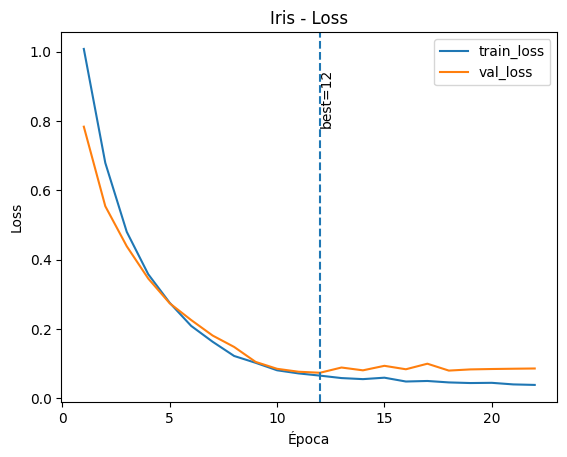

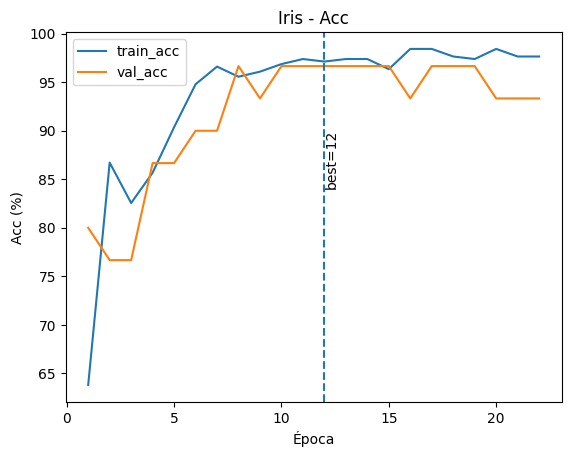

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.96      0.96      0.96        50
           2       0.96      0.96      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150

[[50  0  0]
 [ 0 48  2]
 [ 0  2 48]]
[005] loss=0.7095 acc= 93.4% | vloss=0.6351 vacc= 94.4%
[010] loss=0.2480 acc= 99.4% | vloss=0.2082 vacc=100.0%
[015] loss=0.0743 acc=100.0% | vloss=0.0894 vacc= 97.2%
[020] loss=0.0329 acc=100.0% | vloss=0.0723 vacc= 97.2%
[025] loss=0.0185 acc=100.0% | vloss=0.0625 vacc= 97.2%
[030] loss=0.0120 acc=100.0% | vloss=0.0600 vacc= 97.2%
[035] loss=0.0085 acc=100.0% | vloss=0.0589 vacc= 97.2%
[040] loss=0.0063 acc=100.0% | vloss=0.0615 vacc= 97.2%
Paro temprano @ epoch 43 (best=33)


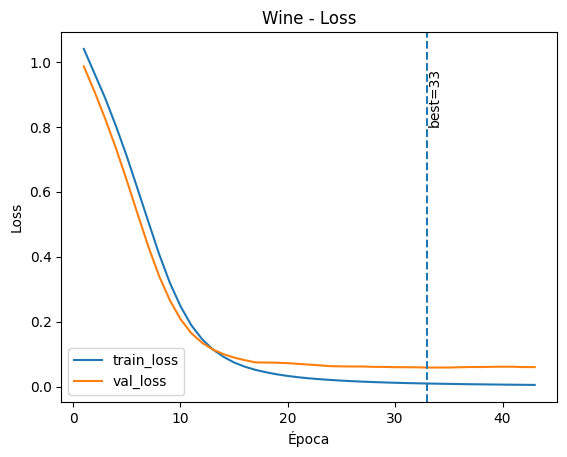

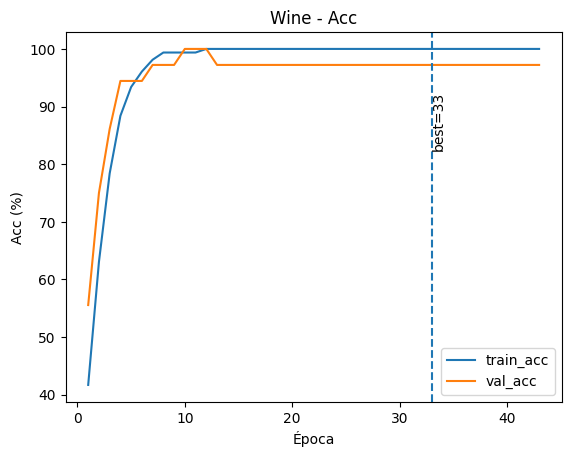

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       0.99      1.00      0.99        71
           2       1.00      0.98      0.99        48

    accuracy                           0.99       178
   macro avg       1.00      0.99      0.99       178
weighted avg       0.99      0.99      0.99       178

[[59  0  0]
 [ 0 71  0]
 [ 0  1 47]]


In [ ]:

# [Entrenamientos y gráficos]
set_seed(0)

# Random (binario)
rnd = RandomDataSet(N=500, D=20, seed=0)
model_rnd, hist_rnd, best_rnd = loop_FFNN(rnd, batch_size=64, d1=64, d2=64, lr=1e-2, epochs=60,
                                         early_stopping=True, log_history=False)
plot_history(hist_rnd, best_epoch=best_rnd, title='Random')
print("Eval Random:", evaluate(model_rnd, TensorDataset(rnd.X, rnd.y), binary=True)['acc'])

# Breast Cancer (binario)
bc = BreastCancerBinaryDataset(standardize=True)
model_bc, hist_bc, best_bc = loop_FFNN(bc, batch_size=32, d1=64, d2=64, lr=1e-3, epochs=200,
                                       early_stopping=True, log_history=False)
plot_history(hist_bc, best_epoch=best_bc, title='Breast Cancer')
ev_bc = evaluate(model_bc, TensorDataset(bc.X, bc.y), binary=True)
print(ev_bc['report'])
print(ev_bc['cm'])

# Iris (multiclase)
iris = IrisDataset(standardize=True)
model_iris, hist_iris, best_iris = loop_FFNN_MC(iris, C=iris.num_classes, batch_size=32, d1=64, d2=64,
                                                lr=5e-3, epochs=200, early_stopping=True, log_history=False)
plot_history(hist_iris, best_epoch=best_iris, title='Iris')
ev_iris = evaluate(model_iris, TensorDataset(iris.X, iris.y), binary=False)
print(ev_iris['report'])
print(ev_iris['cm'])

# Wine (multiclase)
wine = WineDataset(standardize=True)
model_wine, hist_wine, best_wine = loop_FFNN_MC(wine, C=wine.num_classes, batch_size=32, d1=64, d2=64,
                                                lr=1e-3, epochs=200, early_stopping=True, log_history=False)
plot_history(hist_wine, best_epoch=best_wine, title='Wine')
ev_wine = evaluate(model_wine, TensorDataset(wine.X, wine.y), binary=False)
print(ev_wine['report'])
print(ev_wine['cm'])
